**1. IMPORTING LIBRARIES**

In [1]:
import vec2text
import torch
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
import numpy as np
import warnings

# Sopprimiamo i warning
warnings.filterwarnings("ignore")


**2. FUNCTIONS TO OBTAIN EMBEDDING E QUANTIZATIONS**

In [2]:
# Function to obtain embeddings using a GTR
def get_gtr_embeddings(text_list, encoder, tokenizer):
    inputs = tokenizer(
        text_list,
        return_tensors="pt",
        max_length=128,
        truncation=True,
        padding="max_length"
    ).to("cuda")

    with torch.no_grad():
        model_output = encoder(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        hidden_state = model_output.last_hidden_state
        embeddings = vec2text.models.model_utils.mean_pool(hidden_state, inputs['attention_mask'])

    return embeddings

# Function to quantize embeddings
def quantize_embeddings(embeddings, bits=8):
    scale = 2 ** bits - 1
    embeddings_min = embeddings.min(dim=-1, keepdim=True).values
    embeddings_max = embeddings.max(dim=-1, keepdim=True).values
    quantized = ((embeddings - embeddings_min) / (embeddings_max - embeddings_min)) * scale
    quantized = quantized.round().to(torch.uint8)  # Convertiamo a uint8
    return quantized, embeddings_min, embeddings_max

# Function to DEquantize embeddings
def dequantize_embeddings(quantized, embeddings_min, embeddings_max, bits=8):
    scale = 2 ** bits - 1
    quantized = quantized.to(torch.float32)  # Convertiamo a float32 per operazioni
    dequantized = (quantized / scale) * (embeddings_max - embeddings_min) + embeddings_min
    return dequantized

# Function to calculate the compression percentage
def calculate_compression_percentage(original_embeddings, quantized_embeddings):
    original_size = original_embeddings.numel() * original_embeddings.element_size()
    quantized_size = quantized_embeddings.numel() * quantized_embeddings.element_size()
    compression_ratio = (original_size - quantized_size) / original_size * 100
    return compression_ratio

**3. LOAD THE MODELS**

In [3]:
encoder = AutoModel.from_pretrained("sentence-transformers/gtr-t5-base").encoder.to("cuda")
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/gtr-t5-base")
corrector = vec2text.load_pretrained_corrector("gtr-base")

Some weights of T5Model were not initialized from the model checkpoint at sentence-transformers/gtr-t5-base and are newly initialized: ['decoder.block.0.layer.0.SelfAttention.k.weight', 'decoder.block.0.layer.0.SelfAttention.o.weight', 'decoder.block.0.layer.0.SelfAttention.q.weight', 'decoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight', 'decoder.block.0.layer.0.SelfAttention.v.weight', 'decoder.block.0.layer.0.layer_norm.weight', 'decoder.block.0.layer.1.EncDecAttention.k.weight', 'decoder.block.0.layer.1.EncDecAttention.o.weight', 'decoder.block.0.layer.1.EncDecAttention.q.weight', 'decoder.block.0.layer.1.EncDecAttention.v.weight', 'decoder.block.0.layer.1.layer_norm.weight', 'decoder.block.0.layer.2.DenseReluDense.wi.weight', 'decoder.block.0.layer.2.DenseReluDense.wo.weight', 'decoder.block.0.layer.2.layer_norm.weight', 'decoder.block.1.layer.0.SelfAttention.k.weight', 'decoder.block.1.layer.0.SelfAttention.o.weight', 'decoder.block.1.layer.0.SelfAttention.q.weig

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

**4. TEXTS AND EMBEDDINGS**

In [12]:
# Sentence to convert into embeddings
text = "In a quiet corner of the city, hidden among the busy streets and modern skyscrapers, lies a small park that offers an oasis of peace to residents. This park, once part of a large private estate, was redeveloped and opened to the public in the 1980s. Today, its green spaces, tree-lined paths, and serene ponds attract families, joggers, and nature enthusiasts. Visitors can stroll along trails bordered by colorful flowers, relax on benches situated beneath ancient trees, or simply enjoy the tranquility of the landscape. Each year, the park hosts community events and local festivals that celebrate the culture and traditions of the neighborhood. Despite the increasing urbanization around it, this slice of nature remains a cherished refuge for those seeking a moment of relaxation and connection with the natural world."
text_list = text.split('.')[:-1]
# Get embeddings from the sentences
embeddings = get_gtr_embeddings(text_list, encoder, tokenizer)


**5. EXECUTION OF THE OPERATIONS**

In [5]:
q_levels = [2,4,6,8,10,12]
all_texts = []

for lv in q_levels: 
    # Apply quantization
    quantized_embeddings, embeddings_min, embeddings_max = quantize_embeddings(embeddings, bits=lv)

    # Apply dequantization
    dequantized_embeddings = dequantize_embeddings(quantized_embeddings, embeddings_min, embeddings_max, bits=lv)

    # Invert the quantized embeddings to reconstruct the text
    inverted_texts = vec2text.invert_embeddings(
        embeddings=dequantized_embeddings.cuda(),
        corrector=corrector,
        num_steps=20,
        sequence_beam_width=4
    )
    all_texts.append(inverted_texts)


**6. RESULTS**

In [6]:
# Print the inversion results and the compression percentage
or_seq =''
inv_seq =''
i=2
for seq in all_texts:
    for original, inverted, orig_emb, quant_emb in zip(text_list, seq, embeddings, quantized_embeddings):
        compression_percentage = calculate_compression_percentage(orig_emb, quant_emb)
        or_seq += original +'. '
        inv_seq +=inverted + '. '
    print(f"RESULTS WITH {i} BIT QUANTIZATION: \n \n")
    print(f"Original: {or_seq}\n")
    print(f"Quantized: {inv_seq}\n")
    print(f"Compression Percentage: {compression_percentage:.2f}%\n \n")
    or_seq =''
    inv_seq =''
    i+=2

RESULTS WITH 2 BIT QUANTIZATION: 
 

Original: In a quiet corner of the city, hidden among the busy streets and modern skyscrapers, lies a small park that offers an oasis of peace to residents.  This park, once part of a large private estate, was redeveloped and opened to the public in the 1980s.  Today, its green spaces, tree-lined paths, and serene ponds attract families, joggers, and nature enthusiasts.  Visitors can stroll along trails bordered by colorful flowers, relax on benches situated beneath ancient trees, or simply enjoy the tranquility of the landscape.  Each year, the park hosts community events and local festivals that celebrate the culture and traditions of the neighborhood.  Despite the increasing urbanization around it, this slice of nature remains a cherished refuge for those seeking a moment of relaxation and connection with the natural world. 

Quantized: American Freedom Fighters." In modern times, a small park in the northwest corner of the city overlooks the A Q

**7. EVALUATION**

In [10]:
def calculate_cosine_similarity(original_texts, inverted_texts):
    original_embeddings = get_gtr_embeddings(original_texts, encoder, tokenizer)
    inverted_embeddings = get_gtr_embeddings(inverted_texts, encoder, tokenizer)
    cosine_similarities = []
    for orig_emb, inv_emb in zip(original_embeddings, inverted_embeddings):
        similarity = cosine_similarity(orig_emb.cpu().numpy().reshape(1, -1), inv_emb.cpu().numpy().reshape(1, -1))
        cosine_similarities.append(similarity[0][0])
    
    return np.mean(cosine_similarities)

def calculate_bleu_score(original_texts, inverted_texts):
    bleu_scores = []
    for orig, inv in zip(original_texts, inverted_texts):
        reference = orig.split()
        candidate = inv.split()
        bleu_score = sentence_bleu([reference], candidate)
        bleu_scores.append(bleu_score)
    
    return np.mean(bleu_scores)

def calculate_rouge_score(original_texts, inverted_texts):
    rouge = Rouge()
    rouge_scores = []
    for orig, inv in zip(original_texts, inverted_texts):
        scores = rouge.get_scores(inv, orig, avg=True)
        rouge_scores.append(scores)

    avg_rouge_scores = {
        'rouge-1': np.mean([score['rouge-1']['f'] for score in rouge_scores]),
        'rouge-2': np.mean([score['rouge-2']['f'] for score in rouge_scores]),
        'rouge-l': np.mean([score['rouge-l']['f'] for score in rouge_scores])
    }
    
    return avg_rouge_scores

i=2
cosine_similarities = []
bleu_scores = []
rouge_1_scores = []
rouge_2_scores = []
rouge_l_scores = []


for seq in all_texts:
    cosine_similarity_score = calculate_cosine_similarity(text_list, seq)
    bleu_score = calculate_bleu_score(text_list, seq)

    rouge_scores = calculate_rouge_score(text_list, seq)

    print(f"Average Cosine Similarity for {i} bit: {cosine_similarity_score}")
    print(f"Average BLEU Score {i} bit: {bleu_score}")
    print(f"Average ROUGE Scores {i} bit: {rouge_scores}\n")
    i+=2

    #FOR THE PLOTS
    cosine_similarities.append(cosine_similarity_score)
    bleu_scores.append(bleu_score)
    rouge_1_scores.append(rouge_scores['rouge-1'])
    rouge_2_scores.append(rouge_scores['rouge-2'])
    rouge_l_scores.append(rouge_scores['rouge-l'])

Average Cosine Similarity for 2 bit: 0.7190510630607605
Average BLEU Score 2 bit: 4.907903936213913e-79
Average ROUGE Scores 2 bit: {'rouge-1': 0.31948895187773424, 'rouge-2': 0.05467345001822721, 'rouge-l': 0.21354711760006795}

Average Cosine Similarity for 4 bit: 0.941429615020752
Average BLEU Score 4 bit: 0.24606245345170527
Average ROUGE Scores 4 bit: {'rouge-1': 0.6422114556104133, 'rouge-2': 0.35245643294324397, 'rouge-l': 0.5126302542243696}

Average Cosine Similarity for 6 bit: 0.9938096404075623
Average BLEU Score 6 bit: 0.7968464591216896
Average ROUGE Scores 6 bit: {'rouge-1': 0.9657298960102639, 'rouge-2': 0.8561966433906177, 'rouge-l': 0.940974653950443}

Average Cosine Similarity for 8 bit: 0.9972832202911377
Average BLEU Score 8 bit: 0.9310088782608926
Average ROUGE Scores 8 bit: {'rouge-1': 0.9892075188995784, 'rouge-2': 0.9496598589500352, 'rouge-l': 0.9750231217364577}

Average Cosine Similarity for 10 bit: 0.1121525764465332
Average BLEU Score 10 bit: 1.200953621515

**8. PLOT RESULTS**

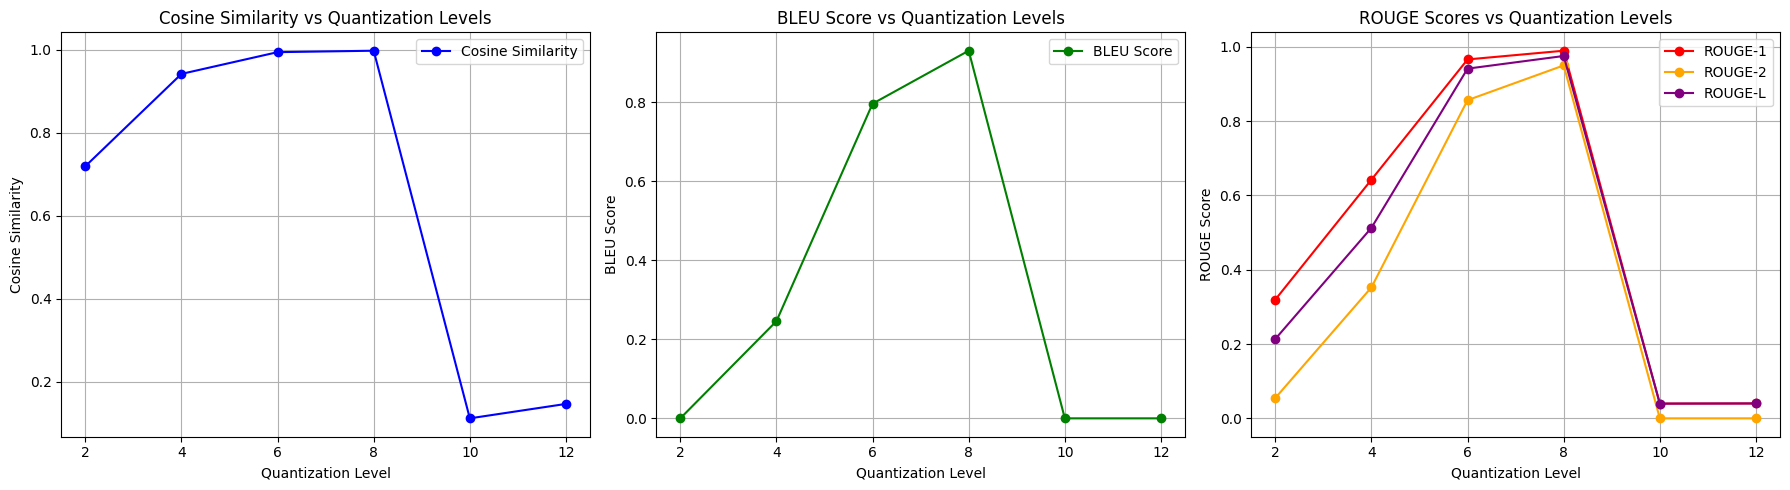

In [11]:
import matplotlib.pyplot as plt

bit_levels = [2, 4, 6, 8, 10, 12]

# Create plots
plt.figure(figsize=(18, 5))

# Cosine similarity plot
plt.subplot(1, 3, 1)
plt.plot(bit_levels, cosine_similarities, marker='o', color='b', label='Cosine Similarity')
plt.title('Cosine Similarity vs Quantization Levels')
plt.xlabel('Quantization Level')
plt.ylabel('Cosine Similarity')
plt.grid(True)
plt.legend()

# BLEU score plot
plt.subplot(1, 3, 2)
plt.plot(bit_levels, bleu_scores, marker='o', color='g', label='BLEU Score')
plt.title('BLEU Score vs Quantization Levels')
plt.xlabel('Quantization Level')
plt.ylabel('BLEU Score')
plt.grid(True)
plt.legend()

# ROUGE scores plot
plt.subplot(1, 3, 3)
plt.plot(bit_levels, rouge_1_scores, marker='o', color='r', label='ROUGE-1')
plt.plot(bit_levels, rouge_2_scores, marker='o', color='orange', label='ROUGE-2')
plt.plot(bit_levels, rouge_l_scores, marker='o', color='purple', label='ROUGE-L')
plt.title('ROUGE Scores vs Quantization Levels')
plt.xlabel('Quantization Level')
plt.ylabel('ROUGE Score')
plt.grid(True)
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


**10. VERIFICA DIFFERENZA EMBEDDIGS**

In [49]:
# Check the difference between original and quantized embeddings
def check_embedding_difference(original_embeddings, quantized_embeddings):
    difference = torch.abs(original_embeddings - quantized_embeddings).sum().item()
    return difference

difference = check_embedding_difference(embeddings, dequantized_embeddings)
print(f"Difference between original and quantized embeddings: {difference:.6f}")


Difference between original and quantized embeddings: 475.153259
